In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
rng = np.random.default_rng()

In [2]:
R_beaker=(114)/2         #outer radius of soil sample mm
r_beaker=84/2            #inner radius of soil sample mm
H_beaker=91-70           #height of top layer sample mm
h_beaker=-70             #bottom point of sample


r_detect=61/2 #radius of detector mm
z_top_detect=-5 #z-value of the top of the detector mm
z_bottom_detect=-5-62 #z-value of the bottom of the detector mm

Res=10**6 #Resolution of simulation

k_absorb=0.0030559129954582 #absorbtion coifecient of the detector (this is just a test value)


Planned_simulation_time = 1 #min

## eff= N_abs/N_not=Sum(P(l))/N_tot, P(l)=1-exp(-kl)

##I need to somehow also consider mass


In [3]:
%%time

Reslow=10**3 #defines the lower resolution to generate the points

#makes 2 random angles
theta, phi = np.random.rand(2,Reslow) 
#makes a unit vector in a random direction
Vectorlow = np.transpose(np.array([np.sin(theta*np.pi)*np.cos(phi*2*np.pi),np.sin(theta*np.pi)*np.sin(phi*2*np.pi),np.cos(theta*np.pi)]))


#array to store values
point_in_soil_low=np.zeros((Reslow,3))
#loop to fill the array
for i in range(Reslow):
        #sets value to initiate while loop
        testpoint=np.ones((3))*R_beaker
        #checks if the point is in the cylinder
        Å=1
        Ø=1
        
        while Å==1 or Ø==1:
            Å=0
            Ø=0
        
            if testpoint[0]**2+testpoint[1]**2>R_beaker**2 or h_beaker>testpoint[2] or testpoint[2]>H_beaker:
                Å=1
        
            if testpoint[0]**2+testpoint[1]**2<r_beaker**2 and 0>testpoint[2]:
                Ø=1
            
            if Å==1 or Ø==1:
                testpoint=np.array([np.random.rand()*R_beaker,np.random.rand()*R_beaker,np.random.rand()*(H_beaker-h_beaker)+h_beaker])
        
            #makes a random point to be checked
            
        #puts the point in the array
        point_in_soil_low[i,:]=testpoint



CPU times: total: 15.6 ms
Wall time: 38.3 ms


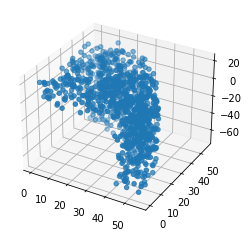

In [4]:
#plotting the random points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(point_in_soil_low[:,0], point_in_soil_low[:,1], point_in_soil_low[:,2])

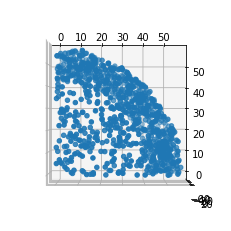

In [5]:
#plotting the random points
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(point_in_soil_low[:,0], point_in_soil_low[:,1], point_in_soil_low[:,2])

ax.view_init(elev=90, azim=-90)




In [6]:
%%time
#makes arrays to store values
EffeciencyArray=np.zeros(60*Planned_simulation_time//5)
EffeciencyGeoArray=np.zeros(60*Planned_simulation_time//5)

#loop 
for i in range(60*Planned_simulation_time//5):
    #generates random numbers
    randomlist=rng.integers(0,Reslow, (2,Res))
    
    #calls random points and direction from the generated set
    point_in_soil=point_in_soil_low[randomlist[0]]
    Vector=Vectorlow[randomlist[1]]

    #makes an empty array to store values
    combined_array = np.zeros((Res,10))
    #inputs the directions
    combined_array[:,:3]=Vector
    #inputs the points
    combined_array[:,3:6]=point_in_soil
    #renames to make writing out a bit easier
    x,y,z,x0,y0,z0= np.transpose(combined_array[:,:6])
    
    #calculates the discriminant for the infinite cylinder
    combined_array[:,6]=((x0*x+y*y0)**2-(x**2+y**2)*(x0**2+y0**2-r_detect**2))
    
    #if the discriminant is negative, return 0 to avoid squareroots of negative numbers
    combined_array[combined_array[:,6] < 0, 6] = 0

    #Find the lenth of the ray to enter the 
    combined_array[:, 7] = np.maximum(np.minimum((z_top_detect - combined_array[:,5])/combined_array[:,2],(z_bottom_detect - combined_array[:,5])/combined_array[:,2]),
                                    np.minimum((-(combined_array[:,0]*combined_array[:,3]+combined_array[:,1]*combined_array[:,4])-np.sqrt(combined_array[:,6]))/(combined_array[:,0]**2+combined_array[:,1]**2),
                                                                   (-(combined_array[:,0]*combined_array[:,3]+combined_array[:,1]*combined_array[:,4])+np.sqrt(combined_array[:,6]))/(combined_array[:,0]**2+combined_array[:,1]**2)))
    combined_array[combined_array[:,6] <= 0, 7] = 0

    combined_array[:, 8] = np.minimum(np.maximum((z_top_detect - combined_array[:,5])/combined_array[:,2],(z_bottom_detect - combined_array[:,5])/combined_array[:,2]),
                                    np.maximum((-(combined_array[:,0]*combined_array[:,3]+combined_array[:,1]*combined_array[:,4])-np.sqrt(combined_array[:,6]))/(combined_array[:,0]**2+combined_array[:,1]**2),
                                                                   (-(combined_array[:,0]*combined_array[:,3]+combined_array[:,1]*combined_array[:,4])+np.sqrt(combined_array[:,6]))/(combined_array[:,0]**2+combined_array[:,1]**2)))
    combined_array[combined_array[:,6] <= 0, 8] = 0

    combined_array[:,9] = combined_array[:,8]-combined_array[:,7]

    combined_array[combined_array[:, 7]<0, 9] = 0 
    combined_array[combined_array[:, 8]<combined_array[:, 7], 9] = 0 

    L=combined_array[:,9]
    LGeo=np.copy(L)
    LGeo[L>0] = 1

    print("Effeciency full[",i,"] =",np.sum(1-np.exp(-k_absorb*L))/Res)
    
    print("Effeciency geo[",i,"] =",np.sum(LGeo)/Res)
    
    EffeciencyArray[i]=np.sum(1-np.exp(-k_absorb*L))/Res
    EffeciencyGeoArray[i]=np.sum(LGeo)/Res
    
    
    
print("Effeciency full=",np.mean(EffeciencyArray), "±", np.std(EffeciencyArray))

print("Geometric Effeciency=",np.mean(EffeciencyGeoArray), "±", np.std(EffeciencyGeoArray))

Effeciency full[ 0 ] = 0.014490204232956954
Effeciency geo[ 0 ] = 0.129848
Effeciency full[ 1 ] = 0.014521267815961237
Effeciency geo[ 1 ] = 0.129878
Effeciency full[ 2 ] = 0.014537373522840845
Effeciency geo[ 2 ] = 0.129798
Effeciency full[ 3 ] = 0.014488084826037223
Effeciency geo[ 3 ] = 0.129679
Effeciency full[ 4 ] = 0.014496012374927737
Effeciency geo[ 4 ] = 0.129604
Effeciency full[ 5 ] = 0.014530195022993296
Effeciency geo[ 5 ] = 0.129924
Effeciency full[ 6 ] = 0.014500773059698557
Effeciency geo[ 6 ] = 0.129901
Effeciency full[ 7 ] = 0.01451901543256141
Effeciency geo[ 7 ] = 0.129983
Effeciency full[ 8 ] = 0.014542468760540453
Effeciency geo[ 8 ] = 0.129907
Effeciency full[ 9 ] = 0.014460888337643406
Effeciency geo[ 9 ] = 0.129796
Effeciency full[ 10 ] = 0.014444934827263799
Effeciency geo[ 10 ] = 0.129569
Effeciency full[ 11 ] = 0.014599607276385828
Effeciency geo[ 11 ] = 0.130519
Effeciency full= 0.014510902124150897 ± 3.898469600528011e-05
Geometric Effeciency= 0.12986716666

In [7]:
%%time
#makes arrays to store values

def Sim(k_fit):
    EffeciencyArray=np.zeros(60*Planned_simulation_time//5)
    EffeciencyGeoArray=np.zeros(60*Planned_simulation_time//5)
    
    
    #loop 
    for i in range(60*Planned_simulation_time//5):
        #generates random numbers
        randomlist=rng.integers(0,Reslow, (2,Res))
    
        #calls random points and direction from the generated set
        point_in_soil=point_in_soil_low[randomlist[0]]
        Vector=Vectorlow[randomlist[1]]

        #makes an empty array to store values
        combined_array = np.zeros((Res,10))
        #inputs the directions
        combined_array[:,:3]=Vector
        #inputs the points
        combined_array[:,3:6]=point_in_soil
        #renames to make writing out a bit easier
        x,y,z,x0,y0,z0= np.transpose(combined_array[:,:6])
    
        #calculates the discriminant for the infinite cylinder
        combined_array[:,6]=((x0*x+y*y0)**2-(x**2+y**2)*(x0**2+y0**2-r_detect**2))
    
        #if the discriminant is negative, return 0 to avoid squareroots of negative numbers
        combined_array[combined_array[:,6] < 0, 6] = 0

        #Find the lenth of the ray to enter the 
        combined_array[:, 7] = np.maximum(np.minimum((z_top_detect - combined_array[:,5])/combined_array[:,2],(z_bottom_detect - combined_array[:,5])/combined_array[:,2]),
                                    np.minimum((-(combined_array[:,0]*combined_array[:,3]+combined_array[:,1]*combined_array[:,4])-np.sqrt(combined_array[:,6]))/(combined_array[:,0]**2+combined_array[:,1]**2),
                                                                   (-(combined_array[:,0]*combined_array[:,3]+combined_array[:,1]*combined_array[:,4])+np.sqrt(combined_array[:,6]))/(combined_array[:,0]**2+combined_array[:,1]**2)))
        combined_array[combined_array[:,6] <= 0, 7] = 0

        combined_array[:, 8] = np.minimum(np.maximum((z_top_detect - combined_array[:,5])/combined_array[:,2],(z_bottom_detect - combined_array[:,5])/combined_array[:,2]),
                                    np.maximum((-(combined_array[:,0]*combined_array[:,3]+combined_array[:,1]*combined_array[:,4])-np.sqrt(combined_array[:,6]))/(combined_array[:,0]**2+combined_array[:,1]**2),
                                                                   (-(combined_array[:,0]*combined_array[:,3]+combined_array[:,1]*combined_array[:,4])+np.sqrt(combined_array[:,6]))/(combined_array[:,0]**2+combined_array[:,1]**2)))
        combined_array[combined_array[:,6] <= 0, 8] = 0

        combined_array[:,9] = combined_array[:,8]-combined_array[:,7]

        combined_array[combined_array[:, 7]<0, 9] = 0 
        combined_array[combined_array[:, 8]<combined_array[:, 7], 9] = 0 

        L=combined_array[:,9]
        LGeo=np.copy(L)
        LGeo[L>0] = 1

        #print("Effeciency full[",i,"] =",np.sum(1-np.exp(-k_fit*L))/Res)
    
        #print("Effeciency geo[",i,"] =",np.sum(LGeo)/Res)
    
        EffeciencyArray[i]=np.sum(1-np.exp(-k_fit*L))/Res
        EffeciencyGeoArray[i]=np.sum(LGeo)/Res
    
    Efficiency_res=np.mean(EffeciencyArray)
    Efficiency_uncert=np.std(EffeciencyArray)#/np.sqrt(len(EffeciencyArray))
        
    return Efficiency_res, Efficiency_uncert
    
    
    


CPU times: total: 0 ns
Wall time: 0 ns


In [8]:
def k_from_E(x):
    a,b,c=1.44658767e+00, 1.11603702e+02, 9.64248141e-04 #values pulled from other file
    return a/(x-b)+c


In [9]:
Energy_array=np.linspace(200,2700,50)

k_array=k_from_E(Energy_array)

In [10]:
%%time
Eff=np.zeros(len(Energy_array))
for i in range(len(Energy_array)):
    print(i*100//len(Energy_array),"%")
    Eff[i]=Sim(k_array[i])[0]

0 %
2 %
4 %
6 %
8 %
10 %
12 %
14 %
16 %
18 %
20 %
22 %
24 %
26 %
28 %
30 %
32 %
34 %
36 %
38 %
40 %
42 %
44 %
46 %
48 %
50 %
52 %
54 %
56 %
58 %
60 %
62 %
64 %
66 %
68 %
70 %
72 %
74 %
76 %
78 %
80 %
82 %
84 %
86 %
88 %
90 %
92 %
94 %
96 %
98 %
CPU times: total: 5min 20s
Wall time: 5min 22s


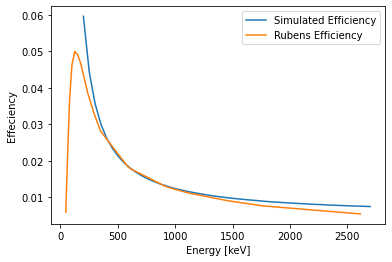

In [11]:
plt.plot(Energy_array,Eff,label="Simulated Efficiency")
X=np.array([46.5, 63.3, 80, 100, 125, 150, 175, 200, 238.8, 295.1, 338.6, 351.9, 583.2, 609.3, 911, 969, 1120.3, 1460.8, 1764.5, 2614.5])
Y=np.array([0.60, 2.26, 3.69, 4.63, 5.00, 4.91, 4.69, 4.36, 3.85, 3.28, 2.91, 2.81, 1.86, 1.79, 1.31, 1.25, 1.12, 0.91, 0.77, 0.55])*1/100
plt.plot(Energy_array,Aliciascurve(Energy_array),label="Calculated Efficiency")

plt.plot(X,Y, label="Rubens Efficiency")
plt.xlabel("Energy [keV]")
plt.ylabel("Effeciency")
plt.legend()


In [12]:
%%time

k_array_compare_Ruben=k_from_E(X[7:])

Eff_compare_Ruben=np.zeros(len(X[7:]))
for i in range(len(X[7:])):
    print(i*100//len(X[7:]),"%")
    Eff_compare_Ruben[i]=Sim(k_array_compare_Ruben[i])[0]

0 %
7 %
15 %
23 %
30 %
38 %
46 %
53 %
61 %
69 %
76 %
84 %
92 %
CPU times: total: 1min 19s
Wall time: 1min 19s


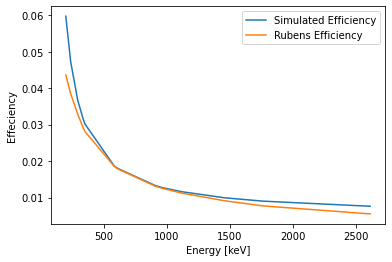

In [13]:
plt.plot(X[7:],Eff_compare_Ruben,label="Simulated Efficiency")
plt.plot(X[7:],Y[7:], label="Rubens Efficiency")
plt.xlabel("Energy [keV]")
plt.ylabel("Effeciency")
plt.legend()


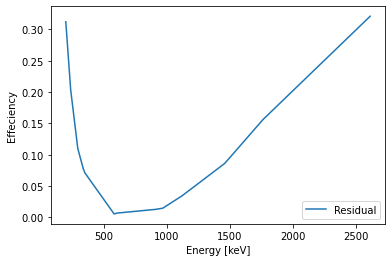

In [14]:
plt.plot(X[7:],(Eff_compare_Ruben-Y[7:])/(Eff_compare_Ruben+Y[7:])*2,label="Residual")
plt.xlabel("Energy [keV]")
plt.ylabel("Effeciency")
plt.legend()

In [15]:
Energy_array

array([ 200.        ,  251.02040816,  302.04081633,  353.06122449,
        404.08163265,  455.10204082,  506.12244898,  557.14285714,
        608.16326531,  659.18367347,  710.20408163,  761.2244898 ,
        812.24489796,  863.26530612,  914.28571429,  965.30612245,
       1016.32653061, 1067.34693878, 1118.36734694, 1169.3877551 ,
       1220.40816327, 1271.42857143, 1322.44897959, 1373.46938776,
       1424.48979592, 1475.51020408, 1526.53061224, 1577.55102041,
       1628.57142857, 1679.59183673, 1730.6122449 , 1781.63265306,
       1832.65306122, 1883.67346939, 1934.69387755, 1985.71428571,
       2036.73469388, 2087.75510204, 2138.7755102 , 2189.79591837,
       2240.81632653, 2291.83673469, 2342.85714286, 2393.87755102,
       2444.89795918, 2495.91836735, 2546.93877551, 2597.95918367,
       2648.97959184, 2700.        ])

In [16]:
Eff

array([0.05964953, 0.04441667, 0.03567478, 0.03005204, 0.02615299,
       0.02334677, 0.02118352, 0.01943244, 0.01805778, 0.01690063,
       0.01593748, 0.01510463, 0.01440606, 0.01377257, 0.0132632 ,
       0.01274843, 0.01231222, 0.01195296, 0.0116027 , 0.01128908,
       0.01100499, 0.01073637, 0.01047967, 0.0102597 , 0.01005904,
       0.00986232, 0.00969296, 0.00953341, 0.00937635, 0.00924496,
       0.00909877, 0.00895668, 0.00882798, 0.00873337, 0.008613  ,
       0.00852448, 0.00842406, 0.00833095, 0.00826307, 0.0081595 ,
       0.00808339, 0.00802644, 0.00793005, 0.00787057, 0.00780218,
       0.00773792, 0.00767979, 0.00763375, 0.00757591, 0.00751838])

In [17]:
k_from_E(803.2)

0.0030559129954582